In [1]:
import numpy as np
import joblib
import os
from os.path import join

In [2]:
import matplotlib.pyplot as plt

In [11]:
plt.rcParams.update({'font.size':16})

# load the calculated metrics

In [40]:
results = joblib.load('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/kl_divergence/KLD_JSD_divergences.pkl')

In [168]:
results8 = joblib.load('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz8_alldaysnets/kl_divergence/KLD_JSD_divergences.pkl')

In [474]:
results4 = joblib.load('/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz4_alldaysnets/kl_divergence/KLD_JSD_divergences.pkl')

In [415]:
results8_2 = joblib.load('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz12_alldaysnets/kl_divergence/KLD_JSD_divergences.pkl')

In [441]:
results12_2 = joblib.load('/home/songbird/datapartition/mdgan_output/daily_gan/r15s12_nz12_alldaysnets/kl_divergence/KLD_JSD_divergences.pkl')

In [41]:
results.keys()

dict_keys(['KLD_tut_pup', 'KLD_pup_tut', 'JFD', 'logLscores', 'model_entropies', 'total_duration'])

In [402]:
KLD_tut_pup = results['KLD_tut_pup']
KLD_pup_tut = results['KLD_pup_tut']
JFD = results['JFD']
entropy = results['model_entropies']
dur = results['total_duration']

In [478]:
results4['logLscores'][0]['50']

array([1.21170303e+01, 7.44594371e-03, 3.51733136e+00, 1.80088778e-02])

In [450]:
r15y5_KLD_tut_pup = results8_2['KLD_tut_pup']
r15y5_KLD_pup_tut = results8_2['KLD_pup_tut']
r15y5_JFD = results8_2['JFD']
r15y5_entropy = results8_2['model_entropies']
r15y5_dur = results8_2['total_duration']

In [451]:
r15s12_KLD_tut_pup = results12_2['KLD_tut_pup']
r15s12_KLD_pup_tut = results12_2['KLD_pup_tut']
r15s12_JFD = results12_2['JFD']
r15s12_entropy = results12_2['model_entropies']
r15s12_dur = results12_2['total_duration']

In [6]:
len(KLD_tut_pup)

35

In [376]:
KLD_tut_pup_K50 = np.array([kld['50'] for kld in KLD_tut_pup])
KLD_tut_pup_K40 = np.array([kld['40'] for kld in KLD_tut_pup])
KLD_tut_pup_K20 = np.array([kld['20'] for kld in KLD_tut_pup])
KLD_tut_pup_K30 = np.array([kld['30'] for kld in KLD_tut_pup])
KLD_tut_pup_K15 = np.array([kld['15'] for kld in KLD_tut_pup])
KLD_tut_pup_K12 = np.array([kld['12'] for kld in KLD_tut_pup])
KLD_tut_pup_K10 = np.array([kld['10'] for kld in KLD_tut_pup])
KLD_tut_pup_K60 = np.array([kld['60'] for kld in KLD_tut_pup if '60' in kld])
KLD_tut_pup_K100 = np.array([kld['100'] for kld in KLD_tut_pup if '100' in kld])

In [465]:
def plot_divergence(div_array, birdname='', divergence_type='JFD',
                    hidden_states=['5','10','12','15','20','25','30','40','50','60','100'],
                    figsize=(12,6), savepath=None):
    
    all_klds = {}
    
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=figsize)
    
    for k in hidden_states:
        
        x = np.log2(np.exp(1.))*np.array([div[k] if k in div else np.nan for div in div_array ])
        all_klds[k] = x
        
        ax.plot(x, '-o', lw=0.5)
        
    plt.legend(hidden_states)
    plt.title(f'{divergence_type} divergence for bird {birdname}')
    
    if savepath is not None:
        plt.savefig(savepath, dpi=100, format='jpg')
        plt.close()
        return all_klds
    
    plt.show()
    
    return all_klds

In [460]:
def plot_entropy(entropy_array, birdname='',
                    hidden_states=['5','10','12','15','20','25','30','40','50','60','100'],
                    figsize=(12,6)):
    
    all_entropies = {}
    
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=figsize)
    
    for k in hidden_states:
        
        x = np.array([ent[k] if k in ent else np.nan for ent in entropy_array ])
        
        all_entropies[k] = x
        pdb.set_trace()
        ax.plot(x.sum(axis=1), '-o', lw=0.5)
        
    plt.legend(hidden_states)
    plt.title(f'Total Entropy for bird {birdname}')
    plt.show()
    
    return all_entropies

In [484]:
def compute_jsd(logLscores):
    """Jenson Shannon Divergence"""
    PlogP = logLscores[0]
    PlogQ = logLscores[1]
    QlogQ = logLscores[2]
    QlogP = logLscores[3]
    
    DKL_P_M = PlogP - np.log(np.exp(PlogP) + np.exp(PlogQ))
    DKL_Q_M = QlogQ - np.log(np.exp(QlogQ) + np.exp(QlogP))
    return 0.5 * (DKL_P_M + DKL_Q_M)


def daily_jsd(logLscores, birdname, divergence_type='JSD',
                    hidden_states=['5','10','12','15','20','25','30','40','50','60','100'],
                    figsize=(12,6), savepath=None):
    
    all_jsds = {}
    ndays = len(logLscores)
    
    for k in hidden_states:
        jsds = []
        for d in range(ndays):
            if k not in logLscores[d]:
                jsd = np.nan
            else:
                logL = logLscores[d][k]
                jsd = compute_jsd(logL)
            jsds.append(jsd)
        all_jsds[k] = np.array(jsds)
        
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=figsize)
    
    for k in hidden_states:
        
        x = np.log2(np.exp(1.)) * all_jsds[k]
        
        ax.plot(x, '-o', lw=0.5)
        
    plt.legend(hidden_states)
    plt.title(f'{divergence_type} divergence for bird {birdname}')
    
    if savepath is not None:
        plt.savefig(savepath, dpi=100, format='jpg')
        plt.close()
        return all_klds
    
    plt.show()
    

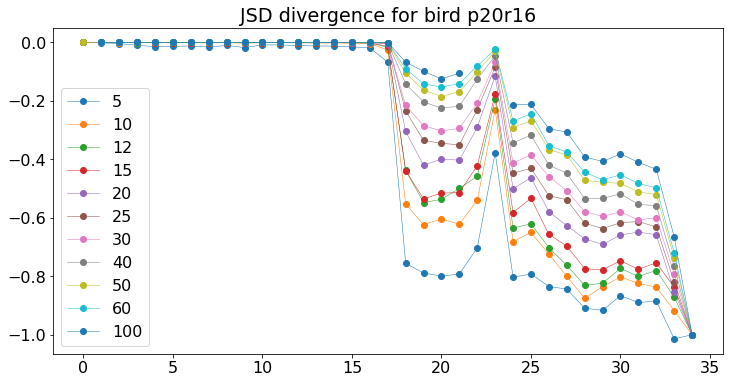

In [485]:
daily_jsd(results['logLscores'], birdname='p20r16')

In [403]:
JFD_K100 = np.array([jfd['100'] for jfd in JFD if '100' in JFD])
JFD_K60 = np.array([jfd['60'] for jfd in JFD if '60' in JFD])
JFD_K10 = np.array([jfd['10'] for jfd in JFD])
JFD_K50 = np.array([jfd['50'] for jfd in JFD])
JFD_K40 = np.array([jfd['40'] for jfd in JFD])
JFD_K20 = np.array([jfd['20'] for jfd in JFD])
JFD_K30 = np.array([jfd['30'] for jfd in JFD])

In [406]:
entropy_K50 = np.array([e['50'] for e in entropy])
entropy_K40 = np.array([e['40'] for e in entropy])
entropy_K30 = np.array([e['30'] for e in entropy])
entropy_K20 = np.array([e['20'] for e in entropy])
entropy_K10 = np.array([e['10'] for e in entropy])

In [144]:
logP_Q = np.array([l['50'] for l in results['logLscores']])
logP_Q.shape

(35, 4)

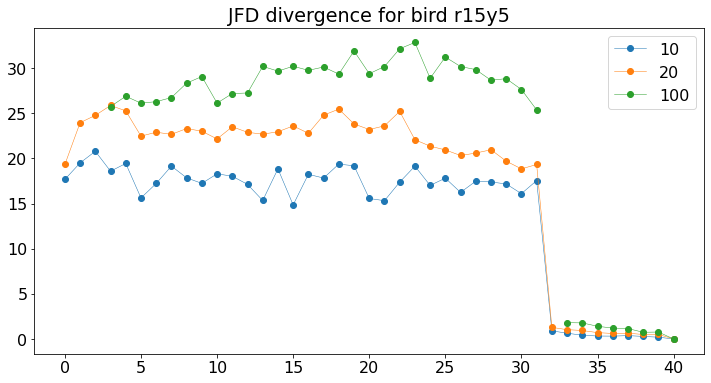

In [437]:
r15y5_jfd_array = plot_divergence(r15y5_JFD, 'r15y5', divergence_type='JFD', hidden_states=['10','20','100'])

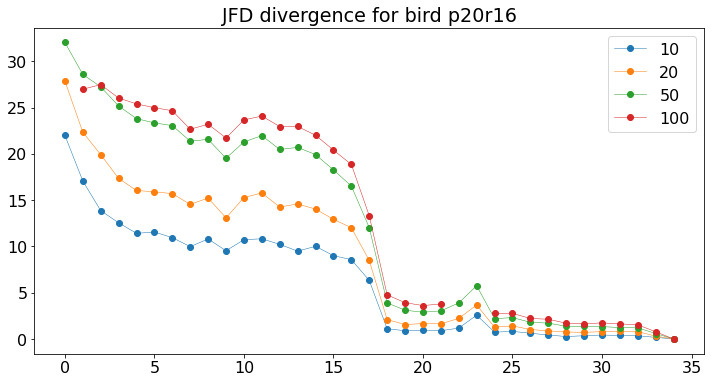

In [448]:
p20r16_jfd_array = plot_divergence(JFD, 'p20r16', divergence_type='JFD', hidden_states=['10','20','50','100'])

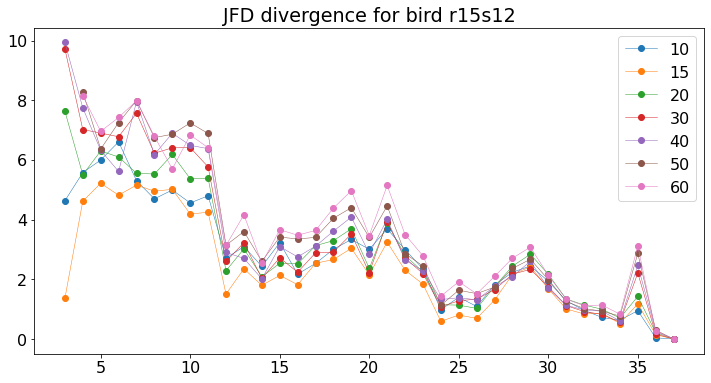

In [467]:
r15s12_jfd_array = plot_divergence(r15s12_JFD, 'r15s12', divergence_type='JFD', hidden_states=['10','15','20','30','40','50','60'],
                                  savepath='/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/r15s12_JFD.jpg')

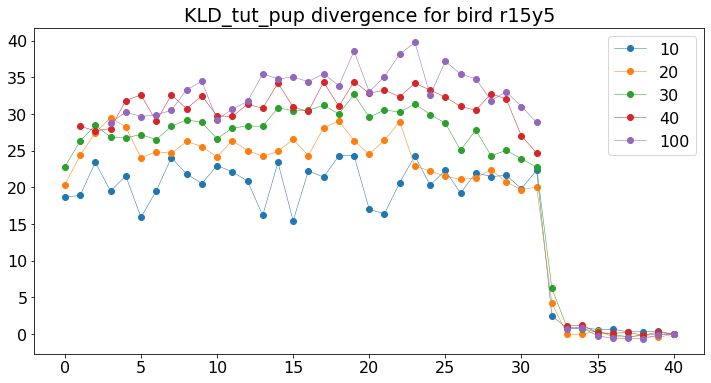

In [468]:
r15y5_kld_tut_pup_array = plot_divergence(r15y5_KLD_tut_pup, 'r15y5', divergence_type='KLD_tut_pup', hidden_states=['10','20','30','40','100'])

In [ ]:
r15y5_ent_array = plot_entropy(r15y5_entropy, birdname='r15y5', hidden_states=['10','20','30','40'])

Text(0, 0.5, 'num spectrogram frames')

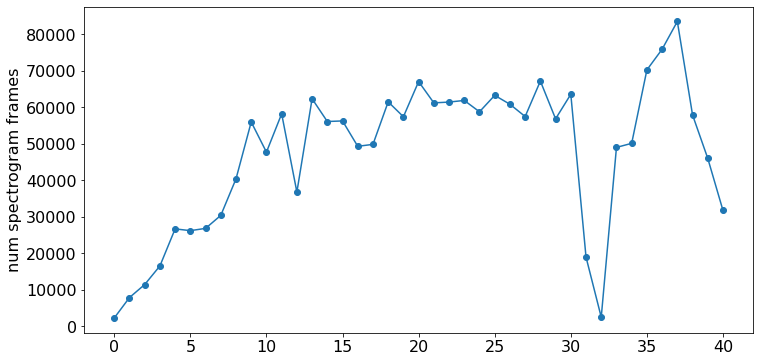

In [442]:
plt.figure(figsize=(12,6))
plt.plot(r15y5_dur, '-o')
plt.ylabel('num spectrogram frames')

Text(0, 0.5, 'Total entropy (Bits)')

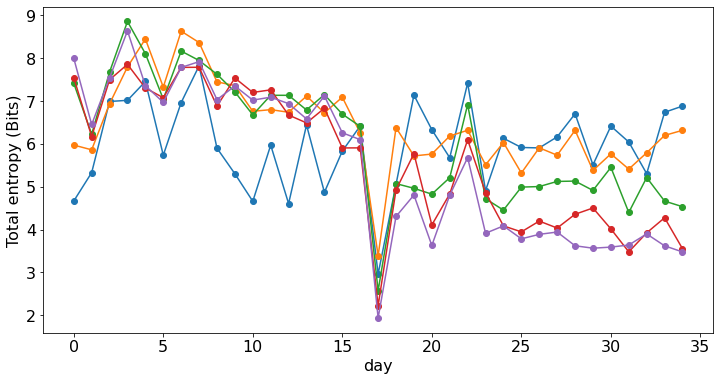

In [410]:
plt.figure(figsize=(12,6))
plt.plot(entropy_K10.sum(axis=-1), '-o')
plt.plot(entropy_K20.sum(axis=-1), '-o')
plt.plot(entropy_K30.sum(axis=-1), '-o')
plt.plot(entropy_K40.sum(axis=-1), '-o')
plt.plot(entropy_K50.sum(axis=-1), '-o')
plt.xlabel('day')
plt.ylabel('Total entropy (Bits)')
#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/p20r16_entropy_nz12_hiddenstates_50_40_30_20_10.jpg',
#           dpi=200, format='jpg')
#plt.close()

In [59]:
entropy_K20.shape

(35, 3)

Text(0, 0.5, 'Emission entropy (Bits)')

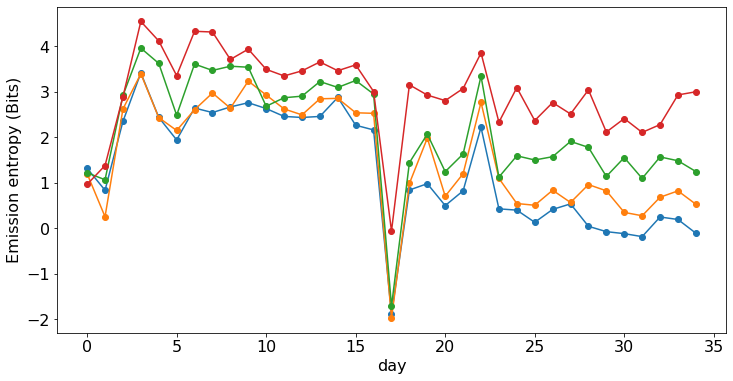

In [357]:
plt.figure(figsize=(12,6))
plt.plot(entropy_K50[:,-1], '-o')
plt.plot(entropy_K40[:,-1], '-o')
plt.plot(entropy_K30[:,-1], '-o')
plt.plot(entropy_K20[:,-1], '-o')
plt.xlabel('day')
plt.ylabel('Emission entropy (Bits)')

Text(0, 0.5, 'Transition entropy (Bits)')

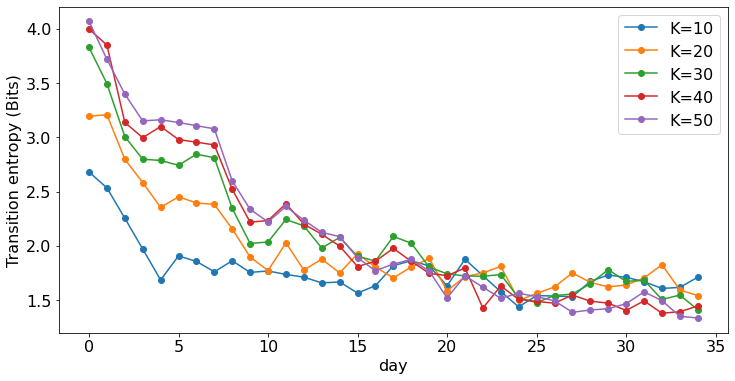

In [471]:
plt.figure(figsize=(12,6))
plt.plot(entropy_K10[:,1], '-o')
plt.plot(entropy_K20[:,1], '-o')
plt.plot(entropy_K30[:,1], '-o')
plt.plot(entropy_K40[:,1], '-o')
plt.plot(entropy_K50[:,1], '-o')
plt.xlabel('day')
plt.legend(['K=10','K=20','K=30','K=40','K=50'])
plt.ylabel('Transition entropy (Bits)')
#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/p20r16_transition_entropy_nz12_hiddenstates_50_40_30_20_10.jpg',
#           dpi=200, format='jpg')
#plt.close()

# correlation between duration and KLD

In [379]:
diff_metric_dur_kld50, sum_metric_dur_kld50 = moving_window_metric(dur, JFD_K50, winlen=10)

In [380]:
diff_metric_dur_kld.shape

(33, 2)

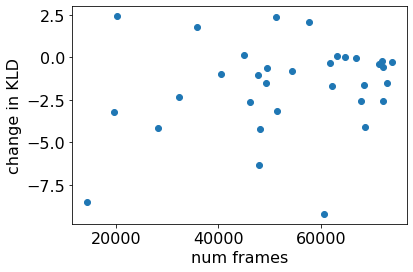

In [384]:
plt.scatter(sum_metric_dur_kld[:,0], diff_metric_dur_kld[:,1])
plt.xlabel('num frames')
plt.ylabel('change in KLD')
plt.show()

In [382]:
spearmanr(sum_metric_dur_kld[:,0], diff_metric_dur_kld[:,1])

SpearmanrResult(correlation=0.16143048128342247, pvalue=0.3694537061719527)

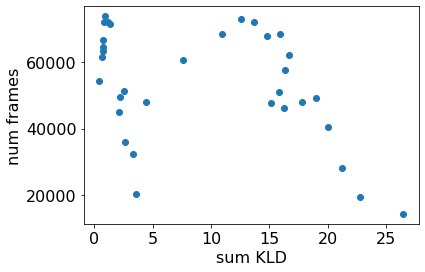

In [394]:
plt.scatter(sum_metric_dur_kld[:,1], sum_metric_dur_kld[:,0])
plt.ylabel('num frames')
plt.xlabel('sum KLD')
plt.show()

In [392]:
spearmanr(sum_metric_dur_kld[:,0], sum_metric_dur_kld[:,1])

SpearmanrResult(correlation=-0.45822192513368987, pvalue=0.00732478238333996)

# between entropy and kld

In [389]:
diff_metric_ent_kld, sum_metric_ent_kld = moving_window_metric(entropy_K50[:,1], jfd, winlen=10)

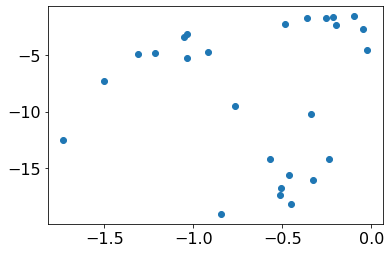

In [390]:
plt.scatter(diff_metric_ent_kld[:,0], diff_metric_ent_kld[:,1])


In [162]:
spearmanr(sum_metric_ent_kld[:,0], sum_metric_ent_kld[:,1])

SpearmanrResult(correlation=0.9555555555555554, pvalue=3.1227033532223407e-14)

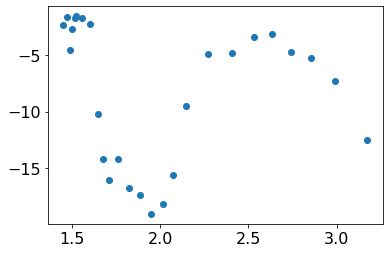

In [388]:
plt.scatter(sum_metric_ent_kld[:,0], diff_metric_ent_kld[:,1])

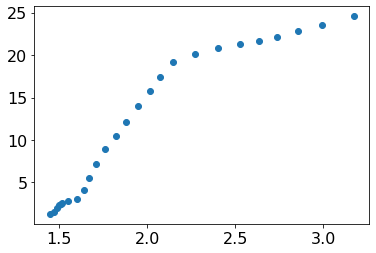

In [387]:
plt.scatter(sum_metric_ent_kld[:,0], sum_metric_ent_kld[:,1])

In [158]:
spearmanr(diff_metric_ent_kld[:,0], diff_metric_ent_kld[:,1])

SpearmanrResult(correlation=0.2909401709401709, pvalue=0.14931413810284552)

# for 8 dimensional data

In [363]:
KLD_tut_pup = results8['KLD_tut_pup']
KLD_pup_tut = results8['KLD_pup_tut']
JFD8 = results8['JFD']
entropy = results8['model_entropies']
dur = results8['total_duration']

In [170]:
KLD_tut_pup_K50_nz8 = np.array([kld['50'] for kld in KLD_tut_pup])
KLD_tut_pup_K40_nz8 = np.array([kld['40'] for kld in KLD_tut_pup])
KLD_tut_pup_K20_nz8 = np.array([kld['20'] for kld in KLD_tut_pup])
KLD_tut_pup_K30_nz8 = np.array([kld['30'] for kld in KLD_tut_pup])

In [364]:
JFD_K50_nz8 = np.array([jfd['50'] for jfd in JFD8])
JFD_K40_nz8 = np.array([jfd['40'] for jfd in JFD8])
JFD_K30_nz8 = np.array([jfd['30'] for jfd in JFD8])
JFD_K20_nz8 = np.array([jfd['20'] for jfd in JFD8])

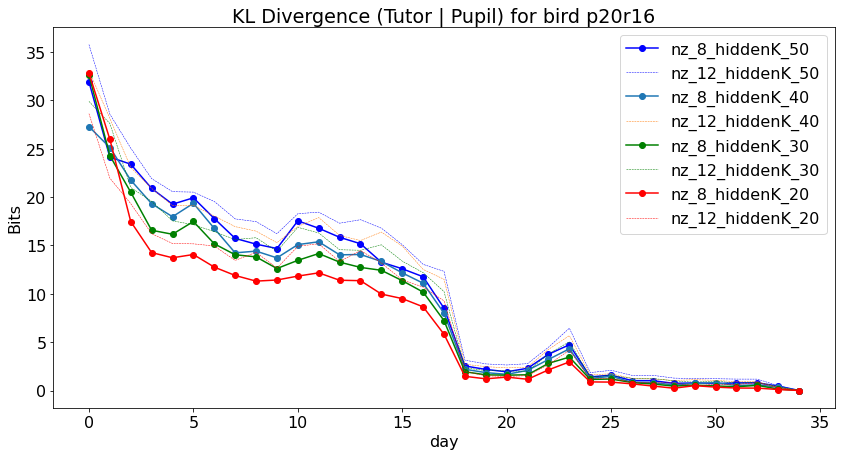

In [368]:
plt.figure(figsize=(14,7))
plt.plot(np.log2(np.exp(1.))*KLD_tut_pup_K50_nz8, '-ob')
plt.plot(np.log2(np.exp(1.))*KLD_tut_pup_K50, '--b', lw=0.5)
plt.plot(np.log2(np.exp(1.))*KLD_tut_pup_K40_nz8, '-o')
plt.plot(np.log2(np.exp(1.))*KLD_tut_pup_K40, '--', lw=0.5)
plt.plot(np.log2(np.exp(1.))*KLD_tut_pup_K30_nz8, '-og')
plt.plot(np.log2(np.exp(1.))*KLD_tut_pup_K30, '--g', lw=0.5)
plt.plot(np.log2(np.exp(1.))*KLD_tut_pup_K20_nz8, '-or')
plt.plot(np.log2(np.exp(1.))*KLD_tut_pup_K20, '--r', lw=0.5)
plt.xlabel('day')
plt.ylabel('Bits')
plt.title('KL Divergence (Tutor | Pupil) for bird p20r16')
plt.legend(['nz_8_hiddenK_50', 'nz_12_hiddenK_50', 'nz_8_hiddenK_40', 'nz_12_hiddenK_40', 
           'nz_8_hiddenK_30', 'nz_12_hiddenK_30', 'nz_8_hiddenK_20', 'nz_12_hiddenK_20'])

#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/p20r16_KLD_tut_pup_nz8_nz12_hiddenstates_50_40_30_20.jpg', dpi=200,
#           format='jpg')
#plt.close()

In [366]:
plt.figure(figsize=(14,7))
plt.plot(np.log2(np.exp(1.)) * JFD_K50_nz8, '-ob')
plt.plot(np.log2(np.exp(1.)) * JFD_K50, '--b', lw=0.5)
plt.plot(np.log2(np.exp(1.)) * JFD_K40_nz8, '-o')
plt.plot(np.log2(np.exp(1.)) * JFD_K40, '--', lw=0.5)
plt.plot(np.log2(np.exp(1.)) * JFD_K30_nz8, '-og')
plt.plot(np.log2(np.exp(1.)) * JFD_K30, '--g', lw=0.5)
plt.plot(np.log2(np.exp(1.)) * JFD_K20_nz8, '-or')
plt.plot(np.log2(np.exp(1.)) * JFD_K20, '--r', lw=0.5)
plt.xlabel('day')
plt.ylabel('Bits')
plt.title('Jeffreys Divergence (Tutor | Pupil) for bird p20r16')
plt.legend(['nz_8_hiddenK_50', 'nz_12_hiddenK_50', 'nz_8_hiddenK_40', 'nz_12_hiddenK_40', 
           'nz_8_hiddenK_30', 'nz_12_hiddenK_30', 'nz_8_hiddenK_20', 'nz_12_hiddenK_20'])

plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure3/p20r16_JFD_tut_pup_nz8_nz12_hiddenstates_50_40_30_20.jpg',
            dpi=200,
           format='jpg')
plt.close()

In [354]:
diff_metric_dur_kld, sum_metric_dur_kld = moving_window_metric(dur, np.log2(np.exp(1.))*KLD_tut_pup_K50_nz8, winlen=3)

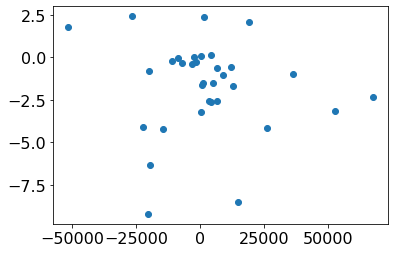

In [355]:
plt.scatter(diff_metric_dur_kld[:,0], diff_metric_dur_kld[:,1])

# moving window correlation

In [472]:
def moving_window_metric(x, y, winlen=10, start=0, jumpby=1):
    """X and Y are arrays, extract windows of some length from it,
        jumping ahead by jumpby. Compute difference and sum metrics
        in each window.
    """
    diff_metric = []
    sum_metric = []
    
    done = False
    idx = start
    
    while not done:
        
        y1 = y[idx : idx+winlen]
        x1 = x[idx : idx+winlen]
        
        idx += jumpby
        
        diff_metric.append(np.array([x1[-1]-x1[0], y1[-1]-y1[0]]))
        sum_metric.append(np.array([x1.sum(), y1.sum()]))
        
        if idx+winlen > len(x):
            done = True
        
    return np.stack(diff_metric), np.stack(sum_metric)

In [76]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'cond_ent': ent})

# order preserving wasserstein

In [274]:
path_to_data1 = '/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/day_11/hmm_hiddensize_50/data_and_scores_day_11.pkl'


In [275]:

path_to_data2 = '/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/day_29/hmm_hiddensize_50/data_and_scores_day_29.pkl'


In [276]:
data2 = joblib.load(path_to_data1)
z2 = data2['ztrain']

In [277]:
data = joblib.load(path_to_data2)
z = data['ztrain']

In [278]:
z[3].shape

(59, 12)

In [279]:
z[2].shape

(45, 12)

In [282]:
z2[6].shape

(41, 12)

In [175]:
from scipy.spatial import distance_matrix

In [285]:
D, Tmap = OPW_dist(z[3], z[3], sigma=5., lambda1=1., lambda2=0.1, num_iters=30)

In [286]:
D

0.001726264957672003

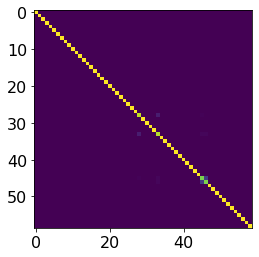

In [287]:
plt.imshow(Tmap)

In [198]:
import pdb

In [288]:
len(z2)

1002

In [ ]:
D_early = np.zeros((len(z2), len(z2)))

for i in range(len(z2)):
    for j in range(i, len(z2)):
        
        D_early[i,j], _ = OPW_dist(z2[i], z2[j], sigma=5., lambda1=1., lambda2=0.1, num_iters=30)

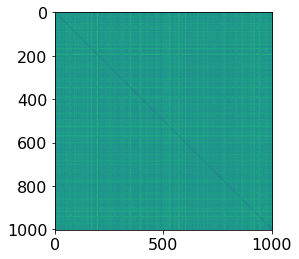

In [302]:
plt.imshow(D_early)

In [301]:
D_e = np.triu(D_early, k=1).T
D_early = D_early + D_e

In [306]:
np.max(D_early)

4.843715244006736

In [319]:
D_e = D_e.flatten()
D_e = D_e[D_e > 0.0]

In [324]:
D_e.shape

(501501,)

In [322]:
D_e.mean()

2.6189172707582875

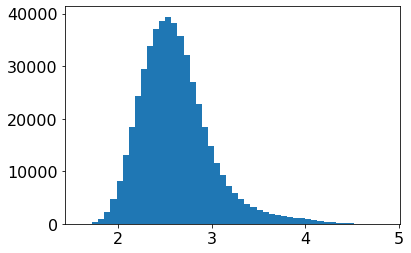

In [321]:
plt.hist(D_e, bins = 50)
plt.show()

In [ ]:
D_late = np.zeros((len(z), len(z)))

for i in range(len(z)):
    for j in range(i, len(z)):
        
        D_late[i,j], _ = OPW_dist(z[i], z[j], sigma=5., lambda1=1., lambda2=0.1, num_iters=30)

In [ ]:
D_early_late = np.zeros((len(z2), len(z)))

for i in range(len(z2)):
    for j in range(len(z)):
        
        D_early_late[i,j], _ = OPW_dist(z2[i], z[j], sigma=5., lambda1=1., lambda2=0.1, num_iters=30)
        
        if i%50==0 and j%200==0:
            print(f'..... {i/len(z2)} percent done .....')

..... 0.0 percent done .....
..... 0.0 percent done .....
..... 0.0 percent done .....
..... 0.0 percent done .....
..... 0.0 percent done .....
..... 0.0499001996007984 percent done .....
..... 0.0499001996007984 percent done .....
..... 0.0499001996007984 percent done .....
..... 0.0499001996007984 percent done .....
..... 0.0499001996007984 percent done .....
..... 0.0998003992015968 percent done .....
..... 0.0998003992015968 percent done .....
..... 0.0998003992015968 percent done .....
..... 0.0998003992015968 percent done .....
..... 0.0998003992015968 percent done .....


In [313]:
D_early_late.shape

(1002, 875)

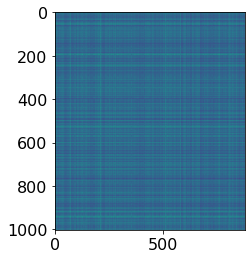

In [314]:
plt.imshow(D_early_late)

In [ ]:
D_early_late

In [323]:
D_e_l = D_early_late.flatten()
D_e_l = D_e_l[D_e_l > 0.]
D_e_l.shape

(876750,)

In [369]:
np.min(D_early_late)

2.4795912229683776

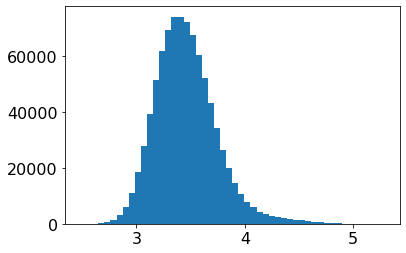

In [326]:
plt.hist(D_e_l, bins=50)
plt.show()

In [332]:
np.argmin(D_early_late[6,:])

769

In [333]:
z[769].shape

(40, 12)

In [327]:
D_e_l.shape

(876750,)

In [189]:
def temporal_cost(i, j, N, M):
    return np.abs( ((i/N) - (j/M))/np.sqrt((1/N**2) + (1/M**2)) )

In [191]:
def prior_prob(i, j, sigma, N, M):
    Z = 1. / sigma*np.sqrt(2 * np.pi)
    return Z * np.exp(-temporal_cost(i, j, N, M)**2 / (2. * (sigma**2)) )

In [220]:
def OPW_dist(X, Y, sigma, lambda1 = 1., lambda2 = 0.5, num_iters = 20):
    
    N = X.shape[0] # num pts in X
    M = Y.shape[0] # num pts in Y
    
    alpha = (1./N) * np.ones(N)
    beta = (1./M) * np.ones(M)
    
    D = distance_matrix(X, Y, p =2)
    
    K = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            
            p = prior_prob(i, j, sigma, N, M)
            s = lambda1 / ( ((i/N) - (j/M))**2 + 1.)
            K[i,j] = p * np.exp((1./lambda2) * (s - D[i,j]))
    
    kappa1 = 1 * alpha
    kappa2 = 1 * beta
    
    for k in range(num_iters):
        
        kappa1 = alpha / (K @ kappa2)
        kappa2 = beta / ( (K.T) @ kappa1)
        
    Tmat = np.diag(kappa1) @ ( K @ np.diag(kappa2) )
    
    return np.trace( (Tmat.T) @ D), Tmat

# generate some spectrograms

In [226]:
from utils.utils import load_netG, overlap_decode, rescale_spectrogram

In [223]:
netGfilepath = '/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/netG_epoch_40_day_all.pth'

netG = load_netG(netGfilepath, nz=12, ngf=128, nc=1, cuda=True, resnet=True)

In [329]:
z2[6].shape

(41, 12)

In [330]:
xx, _ = overlap_decode(z2[6], netG, noverlap=0, get_audio=False, cuda=True)

In [334]:
xx2, _ = overlap_decode(z[769], netG, noverlap=0, get_audio=False, cuda=True)

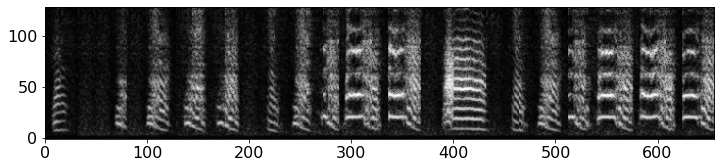

In [331]:
plt.figure(figsize=(12,6))
plt.imshow(rescale_spectrogram(xx), origin='lower', cmap='gray')
plt.show()

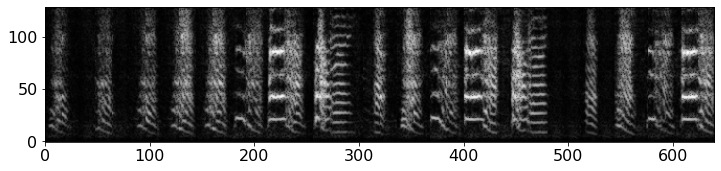

In [335]:
plt.figure(figsize=(12,6))
plt.imshow(rescale_spectrogram(xx2), origin='lower', cmap='gray')
plt.show()

In [224]:
help(overlap_decode)

Help on function overlap_decode in module utils.utils:

overlap_decode(Z, netG, noverlap=0, get_audio=False, cuda=True)
    Overlap decode. For a given numpy array Z of shape (timesteps , latent_dim)
    the output spectrogram (and optionally also audio) is created. 
    Params
    -------
        Z : numpy.ndarray, (timesteps , latent_dim)
        netG : generator neural network
        noverlap  : how much overlap (in spectrogram frames) between 
                    consecutive spectrogram chunks
        get_audio : bool, to generate audio using Griffin Lim
        cuda : bool, if True pushes computation on gpu
    Returns
    -------(timesteps , latent_dim)
        X : numpy.ndarray, (nfft bins , chunks)
        X_audio : numpy array, reconstructed audio



In [ ]:
def cumulative_